# Is Perisher Full of Shit?
Do ski resorts artifically inflate their forecasts to increase business?

### Config 

In [1]:
%load_ext autoreload
%autoreload 2

# imports
import getPerisherForecast
import getTableauWrapper

import pandas as pd
import datetime
import os, sys
import sqlite3

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


# globals
db = "./catch.db"
conn = sqlite3.connect(db)

today = datetime.datetime.strftime(datetime.datetime.today(), '%Y-%m-%d')
print(f"\nLast run: {today}")

You are using the Extract API 2.0, please save the output as .hyper format

Last run: 2020-09-22


### Get Perisher Forecast

In [2]:
perisherWrapper = getPerisherForecast.PerisherWrapper()
df_forecast = perisherWrapper.findPerisherForecast()
print(df_forecast.shape)
df_forecast

(14, 6)


,forecast_date,weather,prob._of_precip,likely_snow,snow_level,wind
0,Tue Sep 22,Mostly cloudy. Rain and snow,80%,2-5cm,1600,Fresh NW
1,Wed Sep 23,Mostly cloudy. Snow showers,80%,2-5cm,1400,Fresh NW
2,Thu Sep 24,Partly cloudy. Snow showers early,40%,<2cm,1200,NW
3,Fri Sep 25,Mostly cloudy. Snow showers,80%,15-30cm,800,NE/NW
4,Sat Sep 26,Mostly cloudy. Snow showers,80%,5-10cm,800,W
5,Sun Sep 27,Snow showers clearing. Sunnier,40%,<2cm,800,SW
6,Mon Sep 28,Early frost. Sunny,5%,Nil,,N to NW
7,Tue Sep 29,Early frost. Sunny,5%,Nil,,N
8,Wed Sep 30,Partly cloudy,10%,Nil,,NE/NW
9,Thu Oct 01,Showers,60%,<2cm,1700,NW


### Parse Forecast

In [3]:

def days_from_actual(r):
    
    scrapped_date = datetime.datetime.strptime(r['scrapped_date'], '%Y-%m-%d')
    # forecast_date = datetime.datetime.strptime(r['forecast_date_parsed'], '%Y-%m-%d %H:%M:%S')
    # print(scrapped_date, forecast_date)

    z = (r['forecast_date_parsed'] - scrapped_date).total_seconds() / (60 * 60 * 24)
    return z

df_forecast['forecast_date_parsed'] = df_forecast['forecast_date'].apply(
    lambda x: datetime.datetime.strptime(x+', 2020', '%a %b %d, %Y')
)

df_forecast['likely_snow_discrete'] = df_forecast['likely_snow'].apply(
    perisherWrapper.parseSnowForecast
)

df_forecast['scrapped_date'] = today

df_forecast['forecast_date_ordinal'] = df_forecast['forecast_date'].apply(
    lambda x: x.split(" ")[0] if pd.notnull(x) else x
)
df_forecast['days_from_actual'] = df_forecast.apply(
    days_from_actual,
    axis=1
)

df_forecast.to_sql(
    'perisherForecast',
    conn,
    if_exists='append'
)

### Format for Tableau

In [4]:
df_all_forecasts = pd.read_sql(
    '''
    SELECT
        P.forecast_date, forecast_date_parsed, wind, 
        likely_snow_discrete, A.actual_snow_discrete,
        scrapped_date, days_from_actual, forecast_date_ordinal
    FROM perisherForecast P

    LEFT JOIN (
        SELECT DISTINCT forecast_date, likely_snow_discrete as actual_snow_discrete
        FROM perisherForecast
        WHERE days_from_actual = 0.0
    ) A ON
        P.forecast_date = A.forecast_date
    ''',
    conn
)

df_all_forecasts['likely_snow_discrete'] = df_all_forecasts['likely_snow_discrete'].apply(
    lambda x: float(x) if pd.notnull(x) else x
)

df_all_forecasts.drop_duplicates(inplace=True)
print(df_all_forecasts.shape)
df_all_forecasts.head()

(499, 8)


,forecast_date,forecast_date_parsed,wind,likely_snow_discrete,actual_snow_discrete,scrapped_date,days_from_actual,forecast_date_ordinal
0,Fri Aug 14,2020-08-14 00:00:00,NE,3.5,3.5,2020-08-14,0.0,Fri
1,Sat Aug 15,2020-08-15 00:00:00,SW,2.0,3.5,2020-08-14,1.0,Sat
2,Sun Aug 16,2020-08-16 00:00:00,SW/NW,3.5,3.5,2020-08-14,2.0,Sun
3,Mon Aug 17,2020-08-17 00:00:00,NW,2.0,2.0,2020-08-14,3.0,Mon
4,Tue Aug 18,2020-08-18 00:00:00,N,22.5,7.5,2020-08-14,4.0,Tue


In [5]:
# write to tableau specific format
getTableauWrapper.makeConversion(df_all_forecasts, "all_forecasts")
getTableauWrapper.cleanLogs()

processing table: 499it [00:00, 17825.91it/s]Table 'Extract' does not exist in extract ./tableau/all_forecasts.hyper, creating.
PYTHON: 22/09/2020 09:08

PYTHON: Directory cleaned
PYTHON: 22/09/2020 09:08



### Vis for Simple Tracking

Text(0.5, 1.0, 'predicted snow fall')

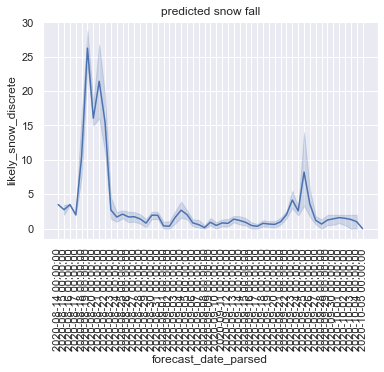

In [6]:
ax = sns.lineplot(x='forecast_date_parsed', y='likely_snow_discrete', data=df_all_forecasts)
plt.xticks(rotation=90)
plt.title('predicted snow fall')

In [7]:
fig = ax.get_figure()
fig.savefig("reports/perisherForecast.png")

### Export

In [8]:

df_all_forecasts.to_csv('./perisherDataExport.csv', index=False)